# Physics-Informed Neural Networks in Chemistry: Game-Changer or Overhyped?

**Note:** All code is available in my Github repository called [Sandbox](https://github.com/ABrethome/Sandbox).
{: .notice}

In chemistry and in life sciences, there exists many use cases that would benefit from models incorporating both an imperfect mechanistic equation and real noisy sparse data.

This is what led a colleague to share a [click-bait article](https://arxiv.org/abs/2505.21723) about Physics-Informed Neural Networks compared to more traditional statistical approaches. This made me read more about the topic to a point where I started to wonder if such a tool was useful in my data-science-in-chemistry toolkit to help my fellow chemists for their specific use cases.

There are lots of papers out there selling PINNs as a game changer toolkit, where AI is described as having the capability of “[accelerating](https://www.youtube.com/watch?v=yxAJohm0l_g&ab_channel=TheRoyalSwedishAcademyofSciences)” or “[revolutionizing](https://www.youtube.com/watch?v=PKN95I93iGE&ab_channel=TheEconomist)” science as we know it. Even AI pioneer Yann LeCun [described it](https://x.com/ylecun/status/1581648953275473921) as a “pretty hot topic, indeed”. There are [lots of research](https://arxiv.org/html/2410.13228v1) trying to expand from PINNs.

So what are Physics-Informed Neural Networks (PINNs)?

Physics-Informed Neural Networks (PINNs) are a class of deep learning models that incorporate physical laws, typically expressed as partial differential equations (PDE), directly into the training process. Unlike traditional neural networks that rely solely on data, PINNs leverage both experimental data and known physical principles to guide learning, ensuring that predictions remain consistent with established scientific knowledge. 

Theoretically, such an approach is promising as it would allow PINNs to solve complex problems in science and engineering, such as modeling chemical reactions or simulating molecular dynamics, even when data is scarce or noisy. One could theoretically also [model the Shrodinger equation](https://arxiv.org/abs/2101.08593). By embedding mechanistic equations into the neural network’s loss function, PINNs have the potential to achieve more accurate and physically meaningful results compared to purely data-driven models.

This is particularly true in chemistry (or life science companies in general!), where it is not rare for data to be sparse or noisy, being because the test is expensive or imperfect or both. Thus, colleagues in research or manufacturing departments want to develop models that must be constrained by real-world physics, in particular when extrapolating from models.

Subject Matter Experts (SME) often come with very specific requests, with the desire to couple mechanistic models with a statistical/ML model with the hope to correct or enhance their mechanistic model.

There are lots of ways to incorporate mechanistic knowledge (perhaps for another blog post!), but here we are going to focus on PINNs.

## Introduction to PINNS in the context of a chemical reaction

I wanted to start my exploration with a (very) simple and directly relevant use case in chemistry.

Let's consider the textbook chemical reaction:

$$ \text{H}_2\text{O}_2 \rightarrow \text{H}_2\text{O} + \frac{1}{2}\text{O}_2 $$

This reaction is governed by the following first-order  kinetic rate law (here, my mechanistic model):

$$ \frac{d[\text{H}_2\text{O}_2]}{dt} = -k[\text{H}_2\text{O}_2] $$

This is an an ordinary differential equation (ODE).
The main difference between ODE and PDE is that an ODE involves derivatives with respect to a single variable (like time here), while a partial differential equation (PDE) involves derivatives with respect to multiple variables (such as time and space).
Here, I have the concentration of hydrogen peroxide, which depends on one variable which is time, describing how the concentration of $\text{H}_2\text{O}_2$ changes over time, and I want a model to be able to predict the concentration of $\text{H}_2\text{O}_2$ during a batch reaction (or whatever).

It can also be written like this:

$$ \frac{d[\text{H}_2\text{O}_2]}{dt} + k[\text{H}_2\text{O}_2] = 0 $$

### Let's use PINN to fit an equation (PDE or ODE)

We have the mechanistic equation describing our chemical system. Without having any data, the first thing one can do is _fit the ODE_ (or PDE).

Our equation is:
$$ \frac{du}{dt} + k u = 0 $$

where:
- $u$ is $[\text{H}_2\text{O}_2]$

Here, we know that the solution function to this ODE is:
$$u = A \exp{(-k t)}$$
where:
- $A$ represents the concentration of $[\text{H}_2\text{O}_2]$ at $t = 0$

We will use it to test predictions compared to the real analytical solution.

Now let's generate a mesh of datapoints, which will be used to train the neural network to fit the PDE:

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

In [ ]:
num_domain = 1000
num_test = 100
minval_pde = 0
maxval_pde = 2
A = 1 # known initial condition given to the system - initial concentration
k = 10 # known textbook rate constant (here, made up)

def generate_uniform_data(num_domain, minval, maxval):
  data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
  return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

t_train_pde = generate_uniform_data(num_domain, minval_pde, maxval_pde)
t_test_pde = generate_uniform_data(num_test, minval_pde, maxval_pde)
t_train_pde.shape, t_test_pde.shape

(TensorShape([1000, 1]), TensorShape([100, 1]))

Here, we define a uniform mesh of $t \in [0, 2]$.
`t_train_pde` and `t_test_pde` represents the mesh we will use to train the neural network to fit the PDE.

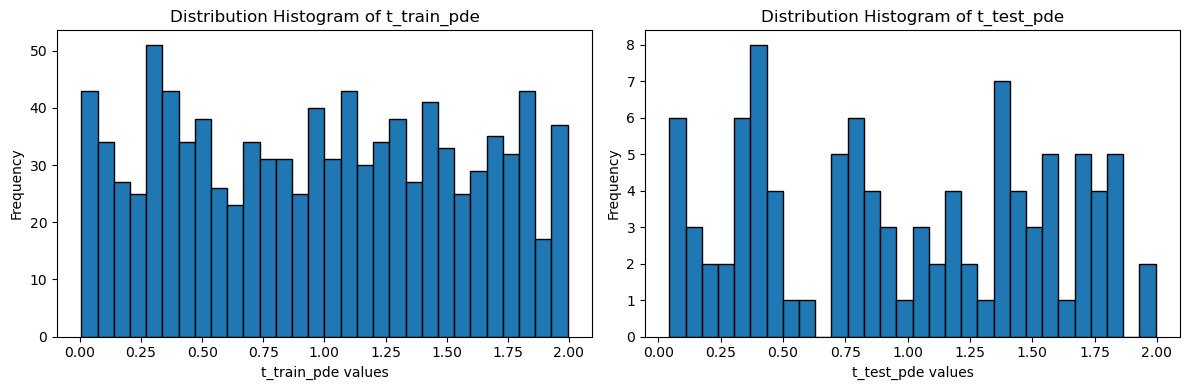

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(t_train_pde.numpy().flatten(), bins=30, edgecolor='k')
axs[0].set_xlabel('t_train_pde values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution Histogram of t_train_pde')

axs[1].hist(t_test_pde.numpy().flatten(), bins=30, edgecolor='k')
axs[1].set_xlabel('t_test_pde values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution Histogram of t_test_pde')

plt.tight_layout()
plt.show()

We can then define our equations:
$$ \frac{du}{dt} + k u = 0 $$
$$ u(0) = A $$
$$u = A \exp{(-k t)}$$

In [4]:
def jacobian(tape, u, t, i=0, j=0):
  if u.shape[1] > 1:
    u = u[:, i : i + 1]

  grads = tape.gradient(u, t)
  return grads[:, j : j + 1]

In [9]:
def pde(tape, t, u):
  du_t = jacobian(tape, u, t)
  return du_t + k * u

def sol_pde(t):
  return A*tf.math.exp(-k*t)

def dirichlet_bc_0(t):
  return A

t_0 = tf.Variable([[0]], trainable=True, dtype=tf.float32)

Once this is defined, one can define the neural network as a simple sequantial architecture:

In [10]:
n_inputs = 1
n_outputs = 1
hidden_units = [5, 5, 5]
activation = 'tanh'

pinn = tf.keras.models.Sequential()
pinn.add(tf.keras.layers.Input((n_inputs,)))

for units in hidden_units:
  pinn.add(tf.keras.layers.Dense(units=units, activation=activation))

pinn.add(tf.keras.layers.Dense(units=n_outputs))
pinn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76 (304.00 B)

 Trainable params: 76 (304.00 B)

 Non-trainable params: 0 (0.00 B)

To finally optimise our neural network:

In [ ]:
epochs = 2000
learning_rate = 0.005

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for i in range(epochs + 1):
  with tf.GradientTape() as tape_model:
    with tf.GradientTape(persistent=True) as tape_pde:
      u = pinn(t_train_pde, training=True)
      u_0 = pinn(t_0, training=True)[0][0]

    domain_error = pde(tape_pde, t_train_pde, u)
    bc1_error = u_0 - dirichlet_bc_0(t_0)

    domain_mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
    bc1_mse =  tf.math.square(bc1_error)
    total_mse = domain_mse + bc1_mse

  model_update_gradients = tape_model.gradient(total_mse, pinn.trainable_variables)
  optimizer.apply_gradients(
    zip(model_update_gradients, pinn.trainable_variables)
  )

  del tape_pde

  if i % 100 == 0:
    u_preds = pinn(t_test_pde)
    test_mse = tf.math.reduce_mean(tf.math.square(u_preds - sol_pde(t_test_pde)), axis=0)
    print('Epoch: {}\tTrain Loss = {},\tTest Loss = {}'.format(i, total_mse.numpy()[0], test_mse.numpy()[0]))

Epoch: 0	Train Loss = 29.94611358642578,	Test Loss = 0.18610796332359314
Epoch: 100	Train Loss = 0.8940415382385254,	Test Loss = 0.012446947395801544
Epoch: 200	Train Loss = 0.8228799104690552,	Test Loss = 0.009959871880710125
Epoch: 300	Train Loss = 0.7808837890625,	Test Loss = 0.008433204144239426
Epoch: 400	Train Loss = 0.7379081845283508,	Test Loss = 0.007376306224614382
Epoch: 500	Train Loss = 0.6824541091918945,	Test Loss = 0.006393138784915209
Epoch: 600	Train Loss = 0.6110419034957886,	Test Loss = 0.00530276820063591
Epoch: 700	Train Loss = 0.5234459042549133,	Test Loss = 0.004070430062711239
Epoch: 800	Train Loss = 0.41796475648880005,	Test Loss = 0.0028229067102074623
Epoch: 900	Train Loss = 0.29546573758125305,	Test Loss = 0.0017008871072903275
Epoch: 1000	Train Loss = 0.16981035470962524,	Test Loss = 0.0008052702178247273
Epoch: 1100	Train Loss = 0.07478900253772736,	Test Loss = 0.00026818280457518995
Epoch: 1200	Train Loss = 0.031986139714717865,	Test Loss = 8.641481690574

Thus, obtaining the followign results:

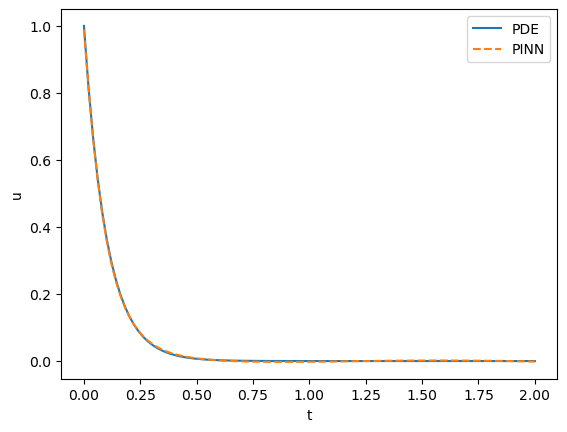

In [45]:
t_test_plot = np.linspace(minval_pde, maxval_pde, num_test)
u_pde_plot = sol_pde(t_test_plot)
u_pred_plot = pinn(t_test_plot)

plt.plot(t_test_plot, u_pde_plot)
plt.plot(t_test_plot, u_pred_plot, '--')
plt.legend(['PDE', 'PINN'])
plt.xlabel("t")
plt.ylabel("u")
plt.show()


We have successfully used a neural network to fit an ODE, and the same principle can be used for more advanced PDEs.

A lot of papers in the literature stop here: PINN in itself can theoretically have value if it allows to compute PDE solution faster than usual solvers. This can be particularly useful in graphic computation, for instance, and some papers report extremely high order of magnitudes faster computation time. That said, there is [a lot of criticisn around some reported applications](https://www.nature.com/articles/s42256-024-00897-5), as it is said a large number of papers take weak baselines to then claim their PINN is the best. In other words, it is easier to claim your method is the best if you are not comparing it to the other state-of-the-art approaches...

### Let's use PINN with experimental data

I don't really PINN to solve ODE/PDE, I want to use to balance mechanistic knowledge with real data.

However, I don't have experimental data, so I will synthesize noisy and sparse data for the purpose of this exploration.
For the data, I will assume I only managed to get some from $t \in [0, 1]$ and my old instrument can't measure lots of data points.
Note that I trained my model with the PDE mesh $t \in [0, 2]$, which means the PDE mesh allows me to train my model in a space where I do not have data.

In [20]:
num_train_data = 30
num_test_data = 10
minval_data = 0
maxval_data = 1

t_train_data = generate_uniform_data(num_train_data, minval_data, maxval_data)
# Add t = 0 to the beginning of t_train_data, this is known as it is the start of a reaction
t_train_data = tf.concat([tf.zeros((1, 1), dtype=t_train_data.dtype), t_train_data], axis=0)
t_test_data = generate_uniform_data(num_test_data, minval_data, maxval_data)
t_train_data.shape, t_test_data.shape

(TensorShape([31, 1]), TensorShape([10, 1]))

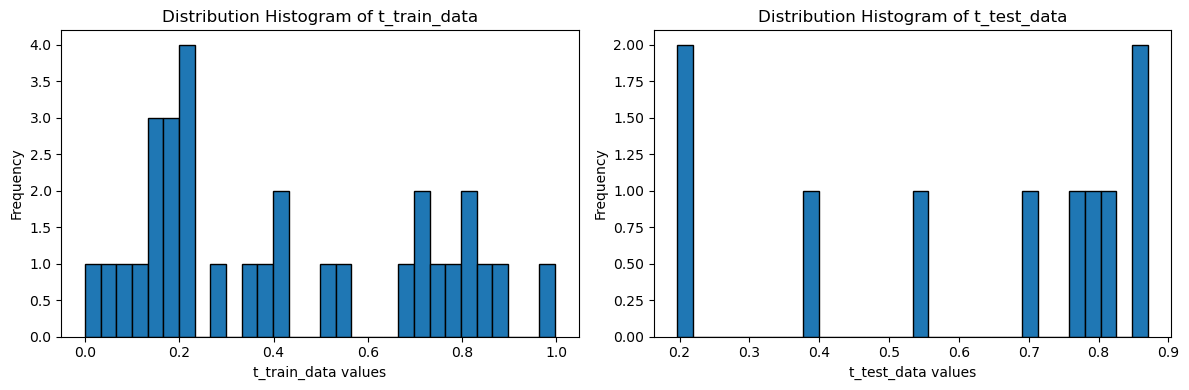

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(t_train_data.numpy().flatten(), bins=30, edgecolor='k')
axs[0].set_xlabel('t_train_data values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution Histogram of t_train_data')

axs[1].hist(t_test_data.numpy().flatten(), bins=30, edgecolor='k')
axs[1].set_xlabel('t_test_data values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution Histogram of t_test_data')

plt.tight_layout()
plt.show()

There is no value of making a PINN if the PDE perfectly describes the chemical system (I would just use the PDE as my model!). Therefore, I will assume that some parameters used in the original equation were wrong, and that the real values are unknown and slightly different.

In our simple use case, one could assume that the textbook kinetic rate is slightly off, where $k_\text{real} = 13$ in reality, but textbook constant is $k_\text{textbook} = 10$. Similarly, one may have planned to add $1 mol/L$, whereas in reality $1.1 mol/L$ was added due to measurement errors.

In [19]:
k_real = 13 # real, unknown rate constant because textbook info is not perfect
A_real = 1.1 # real, unknown initial condition because of measurement errors

We then create a function to conveniently generate datapoints, with noise or not.
Any negative concentration due to noise is set at 0, because negative concentration is impossible.

In [31]:
def generate_u(t, noise = True):
  u = A_real*tf.math.exp(-k_real*t)
  if noise:
    noise = tf.random.normal(shape=tf.shape(u), mean=0.0, stddev=0.03, dtype=u.dtype)
    u = u + noise
  u = tf.where(u < 0, tf.zeros_like(u), u)
  return u

Let's generate our noisy and sparse data:

In [32]:
u_train_data = generate_u(t_train_data)
u_test_data = generate_u(t_test_data)

Let's visualize our newly created data:

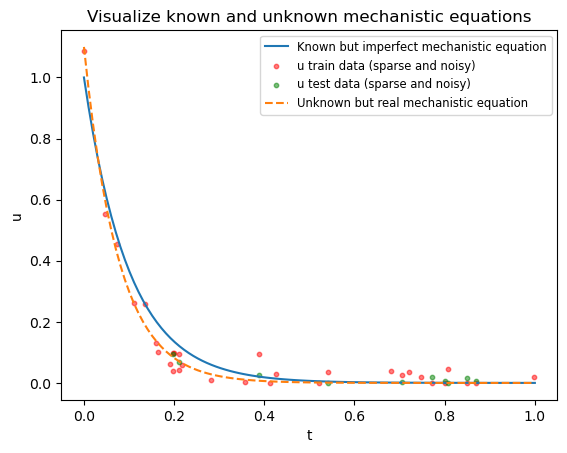

In [33]:
t_test_plot = np.linspace(0, 1, 100)
u_mech_plot = sol_pde(t_test_plot)

plt.plot(t_test_plot, u_mech_plot, label="Known but imperfect mechanistic equation")

plt.scatter(t_train_data.numpy().flatten(), u_train_data.numpy().flatten(), color='red', label='u train data (sparse and noisy)', s=10, alpha=0.5)
plt.scatter(t_test_data.numpy().flatten(), u_test_data.numpy().flatten(), color='green', label='u test data (sparse and noisy)', s=10, alpha=0.5)

plt.plot(t_test_plot, generate_u(t_test_plot, noise = False), "--", label="Unknown but real mechanistic equation", )

plt.title('Visualize known and unknown mechanistic equations')
plt.xlabel("t")
plt.ylabel("u")
plt.legend(loc='upper right', fontsize='small')
plt.show()

Let's make a new model to take into account the data loss:

In [34]:
n_inputs = 1
n_outputs = 1
hidden_units = [5, 5, 5]
activation = 'tanh'
last_ep = 0

pinn_with_data = tf.keras.models.Sequential()
pinn_with_data.add(tf.keras.layers.Input((n_inputs,)))

for units in hidden_units:
  pinn_with_data.add(tf.keras.layers.Dense(units=units, activation=activation))

pinn_with_data.add(tf.keras.layers.Dense(units=n_outputs))
pinn_with_data.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76 (304.00 B)

 Trainable params: 76 (304.00 B)

 Non-trainable params: 0 (0.00 B)

And we can train the newly made model by adding the data loss, and some weights. Here, we significantly overweight the data loss because we want the neural network to prefer the data when there is some:

In [35]:
epochs = int(5e3)
learning_rate = 0.005

# weight of losses 
w_d = 100. # weight for data loss
w_b = 1. # weight for boundary condition loss
w_r = 1. # weight for residual PDE loss

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

if last_ep == 0:
  ep_log = []
  loss_log = []
  loss_log_d = []
  loss_log_b = []
  loss_log_r = []

for i in range(epochs + 1):
  # to handle restarts
  if i <= last_ep:
    continue

  with tf.GradientTape() as tape_model:
    u = pinn_with_data(t_train_data, training=True)
    data_error = u - u_train_data

    with tf.GradientTape(persistent=True) as tape_pde:
      u = pinn_with_data(t_train_pde, training=True)
      u_0 = pinn_with_data(t_0, training=True)[0][0]

      domain_error = pde(tape_pde, t_train_pde, u)
      bc1_error = u_0 - dirichlet_bc_0(t_0)

    domain_mse = w_r * tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
    bc1_mse =  w_b * tf.math.square(bc1_error)
    data_mse = w_d * tf.math.reduce_mean(tf.math.square(data_error), axis=0)
    total_mse = domain_mse + bc1_mse + data_mse

  model_update_gradients = tape_model.gradient(total_mse, pinn_with_data.trainable_variables)
  optimizer.apply_gradients(
    zip(model_update_gradients, pinn_with_data.trainable_variables)
  )

  del tape_pde
  last_ep = i

  if i % 100 == 0:
    ep_log.append(i)
    loss_log.append(total_mse.numpy()[0])
    loss_log_d.append(data_mse.numpy())
    loss_log_b.append(bc1_mse.numpy())
    loss_log_r.append(domain_mse.numpy()[0])

    u_preds_data = pinn_with_data(t_test_data)
    # when there is data, one will use data to compute validation loss with MSE
    test_mse = tf.math.reduce_mean(tf.math.square(u_preds_data - u_test_data), axis=0)
    print('Epoch: {}\tTrain Loss = {},\tTest Loss = {}'.format(i, total_mse.numpy()[0], test_mse.numpy()[0]))

Epoch: 100	Train Loss = 5.403824329376221,	Test Loss = 0.0015255033504217863
Epoch: 200	Train Loss = 4.362617492675781,	Test Loss = 0.002639367710798979
Epoch: 300	Train Loss = 3.7322466373443604,	Test Loss = 0.0025056388694792986
Epoch: 400	Train Loss = 3.091109037399292,	Test Loss = 0.0028366749174892902
Epoch: 500	Train Loss = 2.543715715408325,	Test Loss = 0.0032631088979542255
Epoch: 600	Train Loss = 1.9984121322631836,	Test Loss = 0.0029061909299343824
Epoch: 700	Train Loss = 1.4075415134429932,	Test Loss = 0.002065525855869055
Epoch: 800	Train Loss = 0.8695377111434937,	Test Loss = 0.0011641948949545622
Epoch: 900	Train Loss = 0.49617093801498413,	Test Loss = 0.0005380382062867284
Epoch: 1000	Train Loss = 0.2987344264984131,	Test Loss = 0.00023836246691644192
Epoch: 1100	Train Loss = 0.2130076289176941,	Test Loss = 0.0001271881628781557
Epoch: 1200	Train Loss = 0.17999176681041718,	Test Loss = 9.375972877023742e-05
Epoch: 1300	Train Loss = 0.1682303547859192,	Test Loss = 8.70742

To better understand what happens, let's plot each loss separately:

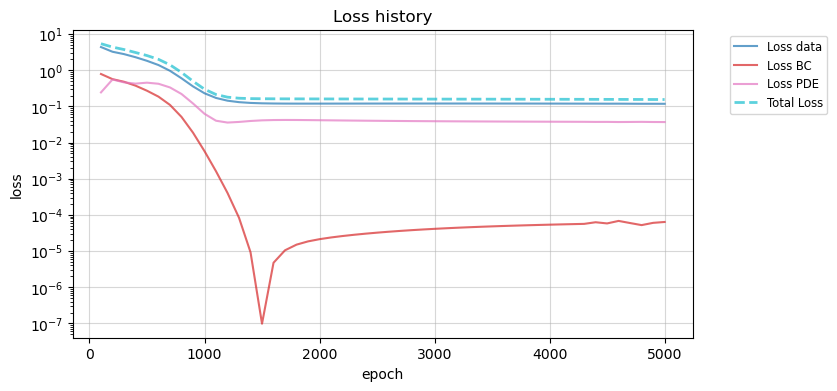

In [36]:
plt.figure(figsize=(8, 4))
colors = plt.get_cmap('tab10', 4)
plt.plot(ep_log, loss_log_d, alpha=.7, color=colors(0), label="Loss data" )
plt.plot(ep_log, loss_log_b, alpha=.7, color=colors(1), label="Loss BC")
plt.plot(ep_log, loss_log_r, alpha=.7, color=colors(2), label="Loss PDE")
plt.plot(ep_log, loss_log, '--', lw=2, alpha=.7, color=colors(3), label="Total Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Loss history")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(alpha=.5)
plt.show()

We can then visualize the result:

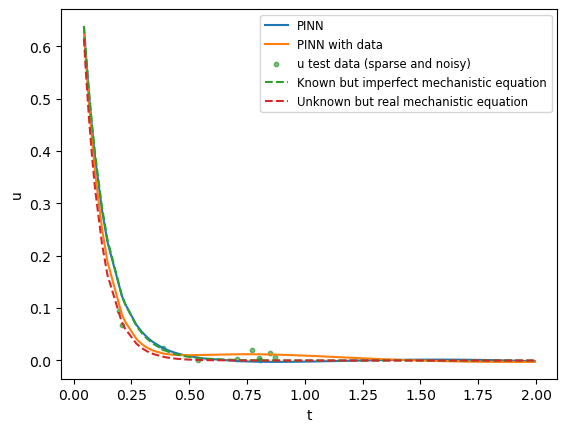

In [44]:
t_test_plot = t_test_pde.numpy().flatten()
sorted_indices_for_pde = np.argsort(t_test_plot)
t_test_plot = t_test_plot[sorted_indices_for_pde]

t_test_data_plot = t_test_data.numpy().flatten()
sorted_indices_for_data = np.argsort(t_test_data_plot)
t_test_data_sorted = t_test_data_plot[sorted_indices_for_data]
u_test_data_sorted = u_test_data.numpy().flatten()[sorted_indices_for_data]

u_pred_plot = pinn(t_test_plot)
u_pred_with_data_plot = pinn_with_data(t_test_plot)


plt.plot(t_test_plot, u_pred_plot, label="PINN")
plt.plot(t_test_plot, u_pred_with_data_plot, label="PINN with data")
plt.scatter(t_test_data_sorted, u_test_data_sorted, color='green', label='u test data (sparse and noisy)', s=10, alpha=0.5)
plt.plot(t_test_plot, sol_pde(t_test_plot), "--", label="Known but imperfect mechanistic equation", )
plt.plot(t_test_plot, generate_u(t_test_plot, noise = False), "--", label="Unknown but real mechanistic equation", )
plt.xlabel("t")
plt.ylabel("u")
plt.legend(loc='upper right', fontsize='small')
plt.show()


One can see that the PINN model with data overfits the data (because of the weight we have put), but at the same time is capable of getting closer to the unknown mechanistic equation.
As desired, it finds a compromise between both as dictated by the different loss weights.

Alright, we successfully create a PINN model with data on a very simple use case.

But is it actually useful?

### Let's create a classic Neural Network to compare

As our baseline, we are going to compare the same neural network architecture, which solely uses the data loss (MSE).

In [38]:
# re-use eaxctly the same hyper parameters again
n_inputs = 1
n_outputs = 1
hidden_units = [5, 5, 5]
activation = 'tanh'
last_ep = 0

nn_with_data = tf.keras.models.Sequential()
nn_with_data.add(tf.keras.layers.Input((n_inputs,)))

for units in hidden_units:
  nn_with_data.add(tf.keras.layers.Dense(units=units, activation=activation))

nn_with_data.add(tf.keras.layers.Dense(units=n_outputs))
nn_with_data.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76 (304.00 B)

 Trainable params: 76 (304.00 B)

 Non-trainable params: 0 (0.00 B)

Because there nothing fancy here, we can leverage the keras compiler out-of-the-box:

In [40]:
epochs = int(5e3)
learning_rate = 0.005

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_mse = keras.losses.MeanSquaredError()

nn_with_data.compile(
    optimizer='adam',
    loss=loss_mse,
    metrics=[keras.metrics.MeanSquaredError()],
)

Let's train the model:

In [41]:
history = nn_with_data.fit(
    t_train_data, 
    u_train_data, 
    epochs=epochs, 
    batch_size=64,
    shuffle=True,
    validation_data=(t_test_data, u_test_data), 
    verbose=1
)

Epoch 1/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1848 - mean_squared_error: 0.1848 - val_loss: 0.1686 - val_mean_squared_error: 0.1686
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - val_loss: 0.1556 - val_mean_squared_error: 0.1556
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1432 - val_mean_squared_error: 0.1432
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1528 - mean_squared_error: 0.1528 - val_loss: 0.1314 - val_mean_squared_error: 0.1314
Epoch 5/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - val_loss: 0.1202 - val_mean_squared_error: 0.1202
Epoch 6/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1337 - mean_squared_error: 0.1337 - val_loss: 0.1095 - val_mean_squared_error: 0.1095
Epoch 7/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1249 - mean_squared_error: 0.1249 - val_loss: 0.0994 - val_

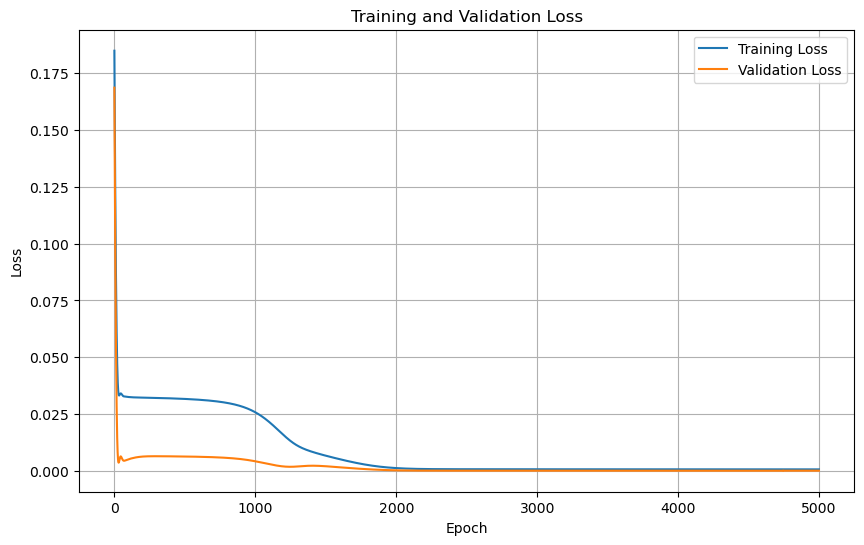

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Let's compare the baseline with the previous models:

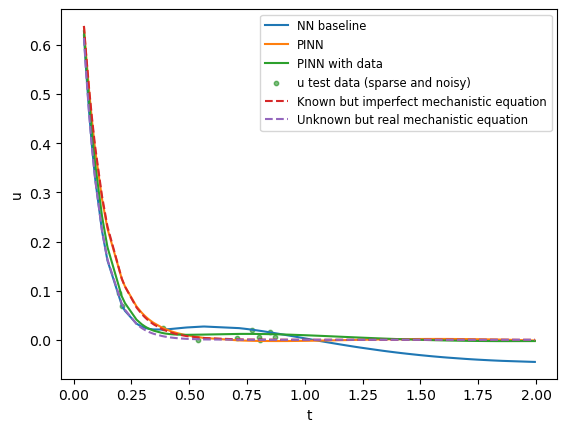

In [46]:
t_test_plot = t_test_pde.numpy().flatten()
sorted_indices_for_pde = np.argsort(t_test_plot)
t_test_plot = t_test_plot[sorted_indices_for_pde]

t_test_data_plot = t_test_data.numpy().flatten()
sorted_indices_for_data = np.argsort(t_test_data_plot)
t_test_data_sorted = t_test_data_plot[sorted_indices_for_data]
u_test_data_sorted = u_test_data.numpy().flatten()[sorted_indices_for_data]

u_pred_baseline = nn_with_data(t_test_plot)
u_pred_plot = pinn(t_test_plot)
u_pred_with_data_plot = pinn_with_data(t_test_plot)

plt.plot(t_test_plot, u_pred_baseline, label="NN baseline")
plt.plot(t_test_plot, u_pred_plot, label="PINN")
plt.plot(t_test_plot, u_pred_with_data_plot, label="PINN with data")
plt.scatter(t_test_data_sorted, u_test_data_sorted, color='green', label='u test data (sparse and noisy)', s=10, alpha=0.5)
plt.plot(t_test_plot, sol_pde(t_test_plot), "--", label="Known but imperfect mechanistic equation", )
plt.plot(t_test_plot, generate_u(t_test_plot, noise = False), "--", label="Unknown but real mechanistic equation", )
plt.xlabel("t")
plt.ylabel("u")
plt.legend(loc='upper right', fontsize='small')
plt.show()


If you remember, we have the PDE mesh $t \in [0, 2]$ whereas we only collected data where $t \in [0, 1]$. Thus, the baseline neural network is only trained on $t \in [0, 1]$. The baseline intrapolation therefore is where $t \in [0, 1]$ and anything outside this range is extrapolation. Unfortunately, the baseline model extrapolates negative concentrations, because there has been no physical constraints.

On the contrary, the PINN with data model is capable of fitting the data in the region where it is available, and at the same can extrapolate thanks to the mesh provided to generate data artificially using the PDE. The PINN with data is literally a compromise between both the data and the mechanistic equation.

## Conclusion

It is important to note that the example presented here is intentionally simple. Through this exploration of PINNs, several key observations emerged:

**Challenges and considerations with PINNs:**
- The convergence of PINNs is influenced by numerous factors, including the choice of initializer, optimizer, and mesh. It is common for training to become trapped in local minima or converge to trivial solutions, especially when working with noisy experimental data.
- Careful definition of the mechanistic model is essential. For example, if $u$ represents concentration, a constant solution such as $u(t) = 0$ may minimize the ODE residual but is not informative. Initial and boundary conditions play a critical role in guiding the neural network toward meaningful, non-trivial solutions.
- The initial condition loss is designed to prevent convergence to trivial solutions (e.g., $u(t) = 0$). However, in practice, the ODE loss may favor trivial solutions, while the initial condition loss encourages non-trivial ones. The relative weighting of these losses can therefore be significant.
- The magnitudes of different loss components can vary substantially during training, making it challenging to select appropriate weights. For instance, the initial condition loss may dominate early in training, while the PDE loss can become more significant later.
- In applications involving experimental data, model validation is typically performed using real data and data loss metrics. Validating against synthetic data generated from the mechanistic model primarily assesses the model’s ability to fit the theoretical equation, which may not reflect real-world performance. As a result, increasing the weight of the data loss often improves validation metrics, regardless of the quality of the mechanistic model.

**Reflections on the usefulness of PINNs in chemistry:**
- Theoretical and computational chemistry is likely to leverage such a method, for force fields for instance ([here](https://www.arxiv.org/abs/2504.16381) and [here](https://arxiv.org/abs/2404.13368)). It is straightforward to see the advantage of such a methodology in a field known to be limited by the computational cost of modelling large molecules such as polymers or proteins.
- I see usage in experimental chemistry to be mixed:
    - When an imperfect mechanistic model and experimental data are both available, PINNs can, in principle, leverage both sources of information. However, in practice, the data loss often takes precedence, especially when the mechanistic model is known to be imperfect. If the data loss is heavily weighted relative to the physics loss, the model may perform similarly to a standard neural network regression, except in cases where extrapolation is required (such as the provided example).
    - If a robust mechanistic model exists and data are sparse, PINNs may again be considered. However, if the mechanistic model already provides a good fit to the available data, the added value of a PINN may be limited.
    - In scenarios where both the mechanistic model is simplistic and the data are sparse and noisy, PINNs are unlikely to yield significant improvements. Model performance will remain limited until either the mechanistic understanding improves or more data become available.

In my view, PINNs can be valuable in specific contexts, but they are not universally transformative. As with any method, understanding the appropriate context for their application is crucial; they should be viewed as complementary tools rather than replacements for established approaches such as statistical modeling.

Any paper claiming otherwise is likely facing some form of [conflict of interests](https://www.understandingai.org/p/i-got-fooled-by-ai-for-science-hypeheres?r=2zm2nw&utm_campaign=post&utm_medium=email&triedRedirect=true).

## Bonus

Wow! you've come so far?!

Here is a bonus attempt at using PINN on a more real and more advanced use case.


Let's consider the textbook second-order chemical reaction:

$$
2\,\mathrm{NO}_2 \rightarrow 2\,\mathrm{NO} + \mathrm{O}_2
$$

This reaction is governed by a well-known rate law (here, my mechanistic model):

$$
\frac{d[\text{NO}_2]}{dt} = - k[\text{NO}_2]^2 
$$

This is a non-linear ordinary differential equation (ODE) describing how the concentration of NO<sub>2</sub> changes over time, and I want to have a model to be able to predict the concentration of $\text{NO}_2$ during the batch reaction.

It can also be written like this:
$$
\frac{d[\text{NO}_2]}{dt} + k[\text{NO}_2]^2 =0
$$

Cool, but this is not real world data.

Let's pretend a chemical engineer comes to me with batches of the reaction over time as data.

Let's assume the chemical engineer has observed that the rate of decomposition accelerate depending on the presence or not of a purely-fictional catalyst, which we will call $Catalyst$.

The real rate law guessed by the chemical engineer is:
$$
\frac{d[\text{NO}_2]}{dt} = - k[\text{NO}_2]^2 - k_\text{catalyst}[\text{Catalyst}]^{o_\text{catalyst}} \cdot [\text{NO}_2]
$$

This is what we will want to model with our mechanistic model coupled with a ML component. The chemical engineer does not know $k_\text{catalyst}$ and $o_\text{catalyst}$.


Our model needs to take into account the fact that the catalyst amount can change between batches, the initial concentration of nitrogen dioxyde can be different, and time can be different.

Here is our model:
$$ u(t, c, u_0; \theta) $$

where:
- $u$ is nitrogen dioxyde concentration to predict
- $t$ time
- $c$ catalyst concentration
- $u_0$ is nitrogen dioxyde concentration at the beginning of the batch.
- $\theta$ are the model parameters (weights and biases)

and our ODE can be written like this:
$$
\frac{du}{dt} + k u^2 + a c^b \cdot u = 0
$$


We can define the loss:
$$
\text{Loss} =  \text{Data Loss} + \text{Physic Loss}
$$
In our example, the physical constraints are a mixture of ordinary differential equation and boundary/initial conditions.
$$
\text{Physic Loss} = \text{ODE Loss} + \text{BC Loss} + \text{IC Loss}
$$

Boundary loss describes the non-negativity of a concentration.
Initial condition loss describes the known concentration at which the decomposition starts.

The total loss can be described as follow:
$$
\text{Data Loss} = \text{mean}( (\hat{u}-u )^2 ) 
$$
$$
\text{ODE Loss} = \text{mean}( ( \frac{du}{dt} + k u^2 + a c^b \cdot u )^2 ) 
$$
$$
\text{BC Loss} = \text{mean}( \text{max}(0, -\hat{u})^2 )
$$
$$
\text{IC Loss} = \text{mean}( (\hat{u}(t_0)-u(t_0) )^2 )
$$
where:
- u is the concentration of $\text{NO}_2$
- c is the concentration of $[\text{Catalyst}]$
- t is the time
- $t \in [0, 1]$, $ u \in [0, u_0] $, 
- $u_0$ varies batch to batch, and $u_0 \in [5, 10]$
- $c$ is a constant within a batch, can change between batches. $c \in [0.01, 0.05]$
- $a$ and $b$ represent unknown hyperparameters to fine-tune (with the true values being $a=k_{cat}$ and $b=o_{cat}$)
- the ODE structure is guessed by the Subject Matter Expert (our chemical engineer)



Let's dive into it now!

Let's create experimental data:

In [47]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [ ]:
# define the unknown real reaction rate to generate data
def unknown_real_reaction_rate(u, t, k, a, b, c):
    return -k * u**2 - a * c**b * u


def create_batch_data(u_0, t, k, a, b, c, noise = True):
    # solve the ODE
    u_exp = odeint(unknown_real_reaction_rate, u_0, t, args=(k, a, b, c))
    # Add normal noise to the experimental data
    if noise:
        noise = np.random.normal(loc=0, scale=0.05, size=u_exp.shape)
    u_exp = u_exp + noise
    u_exp[u_exp < 0] = 0 # noising can make concentration negative, set to zero as a concentration cannot be negative
    return u_exp.flatten()

In [49]:
n_batches = 25

# initial condition shared by all batches
k = 0.5 # rate constant, known in chemical engineer's textbook
t = np.linspace(0, 10, 100) # time points
k_cat = 25 # unknown by chemical engineer (black box about catalyst reactivity)
o_cat = 1.2 # order of the catalyst, unknown by chemical engineer (black box)

# generate batches
u_data = np.zeros((n_batches, t.shape[0])) # experimental data for each batch
X_data = np.zeros((n_batches, t.shape[0], 4))  # shape: (n_batches, 100, 4)
for i in range(n_batches):
    # catalyst concentration, known by chemical engineer but changes in batches!
    c = np.random.uniform(0.01, 0.05)
    # initial concentration, known by chemical engineer but changes in batches!
    u_0 = np.random.uniform(5.0, 10.0)

    u_exp = create_batch_data(u_0, t, k, k_cat, o_cat, c)
    # Store the experimental data
    u_data[i, :] = u_exp
    # Store the initial condition and catalyst concentration in X
    X_data[i, :, 0] = t  # time points for this batch
    X_data[i, :, 1] = c  # catalyst concentration for this batch (broadcasted)
    X_data[i, :, 2] = u_0 # initial concentration for this batch (broadcasted)
    X_data[i, :, 3] = i # batch index for this batch (broadcasted)

u_data = u_data.flatten()
X_data = X_data.reshape(-1, 4) # t, c, u_0 and batch index
# Use batch index as groups
groups = X_data[:, 3]
X_data = X_data[:, :3] # remove the batch indices from features

print("Shape of u:", u_data.shape)
print("Shape of X_data:", X_data.shape)
print("Groups:", np.unique(groups))

Shape of u: (2500,)
Shape of X_data: (2500, 3)
Groups: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.]


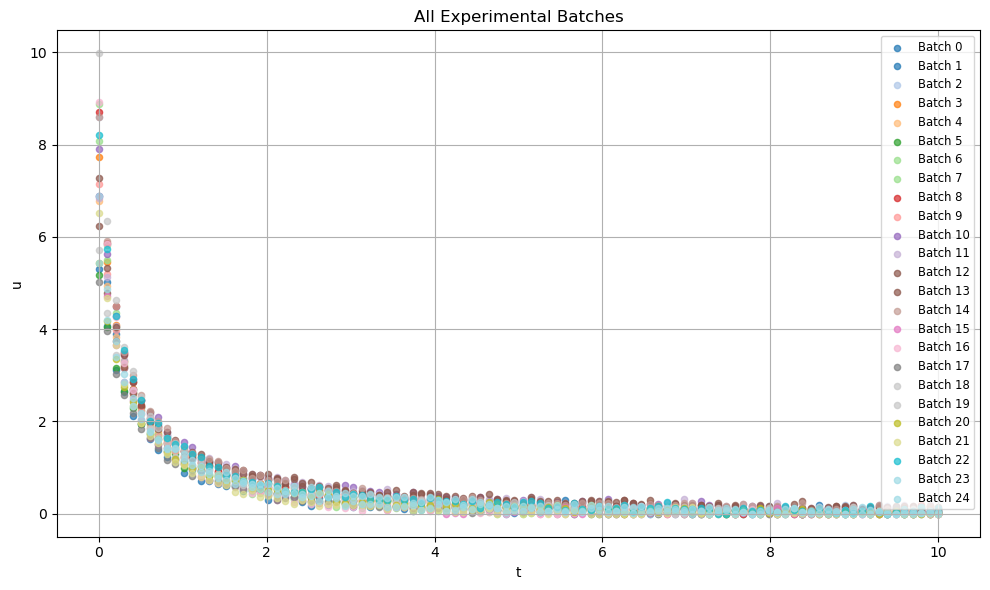

In [50]:
# Plot all experimental batches and the mechanistic theory
plt.figure(figsize=(10, 6))
batch_indices = np.unique(groups)
colors = plt.get_cmap('tab20', len(batch_indices))

for idx, batch in enumerate(batch_indices):
    mask = groups[:] == batch
    plt.scatter(X_data[mask, 0], u_data[mask], color=colors(idx), label=f'Batch {int(batch)}', s=20, alpha=0.7)

plt.legend(loc='upper right', fontsize='small')
plt.title('All Experimental Batches')
plt.xlabel('t')
plt.ylabel('u')
plt.grid(True)
plt.tight_layout()
plt.show()

The objective of our model is to predict the concentration of $\text{NO}_2$ in a **new unseen batch**.

Thus, we will **not** take our testing data randomly, but rather use hold-out batches to externally validate our model, and thus avoid data leakage. 

In [66]:
from sklearn.model_selection import GroupShuffleSplit

# Split: 80% train/val, 20% test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# First split: 80% train_val, 20% test
train_val_idx, test_idx = next(gss.split(X_data, u_data, groups=groups))

# Now split train_val into train and validation (80% train, 20% val of train_val)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss2.split(X_data[train_val_idx], u_data[train_val_idx], groups=groups[train_val_idx]))

# Map indices back to original X/y arrays
train_idx = train_val_idx[train_idx]
val_idx = train_val_idx[val_idx]

X_data_train, X_data_val, X_data_test = X_data[train_idx], X_data[val_idx], X_data[test_idx]
u_data_train, u_data_val, u_data_test = u_data[train_idx], u_data[val_idx], u_data[test_idx]
train_groups, val_groups, test_groups = groups[train_idx], groups[val_idx], groups[test_idx]

X_data_train = X_data_train.astype(np.float32)
u_data_train = u_data_train.astype(np.float32)
X_data_val = X_data_val.astype(np.float32)
u_data_val = u_data_val.astype(np.float32)
X_data_test = X_data_test.astype(np.float32)
u_data_test = u_data_test.astype(np.float32)
u_equal_0 = np.array([0]).astype(np.float32)

print("Train batches: groups=", np.unique(train_groups))
print("Validation batches (used for sweeping): groups=", np.unique(val_groups))
print("Hold out test batches: groups=", np.unique(test_groups))
print("X_data_train shape:", X_data_train.shape, ", u_data_train shape:", u_data_train.shape)
print("X_data_val shape:", X_data_val.shape, ", u_data_val shape:", u_data_val.shape)
print("X_data_test shape:", X_data_test.shape, ", u_data_test shape:", u_data_test.shape)
print("u_equal_0:", u_equal_0, ". This is necessary to know what u='0' is, after u scaling.")

Train batches: groups= [ 3.  4.  5.  6.  7.  9. 10. 12. 13. 14. 15. 17. 18. 20. 22. 24.]
Validation batches (used for sweeping): groups= [ 1.  2. 19. 21.]
Hold out test batches: groups= [ 0.  8. 11. 16. 23.]
X_data_train shape: (1600, 3) , u_data_train shape: (1600,)
X_data_val shape: (400, 3) , u_data_val shape: (400,)
X_data_test shape: (500, 3) , u_data_test shape: (500,)
u_equal_0: [0.] . This is necessary to know what u='0' is, after u scaling.


In [75]:
from sklearn.preprocessing import StandardScaler

# scaling is key with neural networks
scaler_X = StandardScaler()
X_data_train_scaled = scaler_X.fit_transform(X_data_train)
X_data_val_scaled = scaler_X.transform(X_data_val)
X_data_test_scaled = scaler_X.transform(X_data_test)

scaler_u = StandardScaler()
u_data_train_scaled = scaler_u.fit_transform(u_data_train.reshape(-1, 1)).flatten()
u_data_val_scaled = scaler_u.transform(u_data_val.reshape(-1, 1)).flatten()
u_data_test_scaled = scaler_u.transform(u_data_test.reshape(-1, 1)).flatten()
u_equal_0_scaled = scaler_u.transform(u_equal_0.reshape(-1, 1)).flatten()[0]

In [76]:
print("scaled u=0 equals:", u_equal_0_scaled)

scaled u=0 equals: -0.50203454


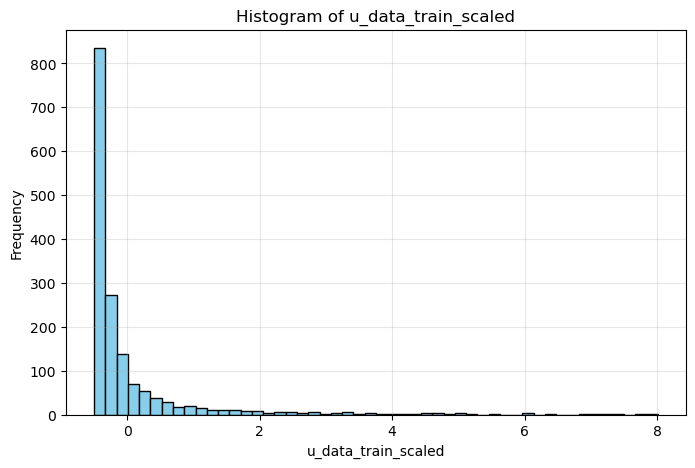

In [77]:
plt.figure(figsize=(8, 5))
plt.hist(u_data_train_scaled, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of u_data_train_scaled')
plt.xlabel('u_data_train_scaled')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

Now we are going to create the mesh for the ODE. 

X_mesh will be used by the ODE loss as well as the boundary condition loss.

In [267]:
# boundaries decided by chemical engineer
t_mesh = np.linspace(0., 10., 40)
c_mesh = np.linspace(0., 0.05, 40)
u_0_mesh = np.linspace(0., 10.0, 40)

# Create a 3D meshgrid
T, C, U0 = np.meshgrid(t_mesh, c_mesh, u_0_mesh, indexing='ij')

# Reshape to (N, 3) where N = 100*100*100
t_flat = T.reshape(-1, 1)
c_flat = C.reshape(-1, 1)
u0_flat = U0.reshape(-1, 1)
X_mesh = np.hstack([t_flat, c_flat, u0_flat])
X_mesh = X_mesh.astype(np.float32)

print("Shape of X_mesh:", X_mesh.shape)

Shape of X_mesh: (64000, 3)


Each row is a combination of $(t, c, u_0)$.

Let's define the initial condition mesh (at $t=0$, $c$ and $u_0$ can be any value):

In [268]:
# boundaries decided by chemical engineer
t_0 = 0
c_0 = np.linspace(0., 0.05, 40)
u_0_0 = np.linspace(0., 10.0, 40)

# Create a 3D meshgrid
T, C, U0 = np.meshgrid(t_0, c_0, u_0_0, indexing='ij')

# Reshape to (N, 3) where N = 100*100*100
t_flat = T.reshape(-1, 1)
c_flat = C.reshape(-1, 1)
u0_flat = U0.reshape(-1, 1)
X_mesh_0 = np.hstack([t_flat, c_flat, u0_flat])
X_mesh_0 = X_mesh_0.astype(np.float32)

u_mesh_0 = u0_flat.astype(np.float32) # at t =0, all inputs (t, c, u0) must be lead to u(t=0) = u0 


print("Shape of X_mesh_0:", X_mesh_0.shape) 
print("Shape of u_mesh_0:", u_mesh_0.shape)

Shape of X_mesh_0: (1600, 3)
Shape of u_mesh_0: (1600, 1)


In [269]:
# scaling is key with neural networks
X_mesh_scaled = scaler_X.transform(X_mesh)
X_mesh_0_scaled = scaler_X.transform(X_mesh_0)

u_mesh_0_scaled = scaler_u.transform(u_mesh_0)

In [270]:
import os
import time
import sys
import datetime
import tensorflow as tf
import numpy as np

class PINN(tf.keras.Model):
    """
    Taken from doi={10.2208/jscejam.77.2_I_35} and adapted to this use case.
    Github:
    https://github.com/ShotaDeguchi/PINN_TF2/tree/main
    """
    def __init__(
        self,
        Rm, Rn, Rl, depth, 
        activ = "tanh", out_activ = "ReLU", 
        BN = False, 
        w_init = "glorot_normal", b_init = "zeros", 
        lr = 1e-3, opt = "Adam", w_d = 1., w_0 = 1., w_b = 1., w_r = 1.,
        k = 0.5, a = 25.0, b = 1.0,
        u_scaled_zero=0.,
        f_mntr = 10, r_seed = 1234
    ):
        
        # initialize the configuration
        super().__init__()
        self.Rm     = Rm             # input dimension
        self.Rn     = Rn             # output dimension
        self.Rl     = Rl             # internal dimension
        self.depth  = depth          # (# of hidden layers) + output layer
        self.activ  = activ          # activation function (except output layer)
        self.out_activ = out_activ   # output activation function
        self.BN     = BN             # Batch normalisation in hidden layers (True/False)
        self.w_init = w_init         # initial weight
        self.b_init = b_init         # initial bias
        self.lr     = lr             # learning rate
        self.opt    = opt            # name of your optimizer ("SGD", "RMSprop", "Adam", etc.)
        self.w_d    = w_d            # weight for data loss
        self.w_0    = w_0            # weight for initial condition loss
        self.w_b    = w_b            # weight for boundary condition loss
        self.w_r    = w_r            # weight for residual ODE loss
        self.r_seed = r_seed         # random seed for reproducibility
        self.f_mntr = f_mntr         # frequency of monitoring loss during training
        self.data_type = tf.float32  # data type for training (tf.float32 or tf.float64)

        # set random seed for reproducibility
        # for numpy, tensorflow, and os
        self.random_seed(seed = self.r_seed)
        
        # for restart
        self.last_epoch = 0

        # call
        self.dnn = self.dnn_init(Rm, Rn, Rl, depth)
        self.params = self.dnn.trainable_variables
        self.optimizer = self.opt_alg(self.lr, self.opt)
        
        # parameter setting
        self.k = tf.constant(k, dtype = self.data_type) # k constant in ODE
        self.a = tf.constant(a, dtype = self.data_type) # a constant in ODE
        self.b = tf.constant(b, dtype = self.data_type) # b constant in ODE
        self.u_scaled_zero = tf.constant(u_scaled_zero, dtype = self.data_type)

        # track loss
        self.ep_log = []
        self.loss_log = []
        self.loss_log_0 = []
        self.loss_log_b = []
        self.loss_log_r = []
        
        print("\n************************************************************")
        print("****************     MAIN PROGRAM START     ****************")
        print("************************************************************")
        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         hidden activ func   :", self.activ)
        print("         output activ func   :", self.out_activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        self.dnn.summary()
        print("************************************************************\n")

    def random_seed(self, seed = 1234):
        os.environ["PYTHONHASHSEED"] = str(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
    def dnn_init(self, Rm, Rn, Rl, depth):
        # network configuration (N: Rm -> Rn (Rm -> Rl -> ... -> Rl -> Rn))
        inputs = tf.keras.layers.Input(
            shape=(Rm,), name="input_layer"
        )
        x = inputs
        if self.BN == True:   # False by default
            # implement batch normalization
            for l in range(depth - 1):
                # When using batch normalization, it is common to disable the bias in the 
                # preceding Dense layer (use_bias=False) because batch normalization already 
                # includes a learnable shift parameter
                x = tf.keras.layers.Dense(
                    Rl, activation = self.activ, use_bias = False,
                    kernel_initializer = self.w_init, bias_initializer = self.b_init, 
                    kernel_regularizer = None, bias_regularizer = None, 
                    activity_regularizer = None, kernel_constraint = None, bias_constraint = None,
                    name=f'layer_dense_{l+1}'
                )(x)
                x = tf.keras.layers.BatchNormalization(
                    axis = -1, momentum = 0.99, epsilon = 0.001, 
                    center = True, scale = True,
                    beta_initializer = "zeros", gamma_initializer = "ones",
                    moving_mean_initializer = "zeros",
                    moving_variance_initializer = "ones", 
                    beta_regularizer = None, gamma_regularizer = None, 
                    beta_constraint  = None, gamma_constraint  = None,
                    name=f'layer_bn_{l+1}'
                )(x)
            
        else: 
            for l in range(depth - 1):
                x = tf.keras.layers.Dense(
                    Rl, activation = self.activ, use_bias = True,
                    kernel_initializer = self.w_init, bias_initializer = self.b_init, 
                    kernel_regularizer = None, bias_regularizer = None, 
                    activity_regularizer = None, kernel_constraint = None, bias_constraint = None,
                    name=f'layer_dense_{l+1}'
                )(x)
        # output layer
        if self.out_activ == "ReLU":
            outputs = tf.keras.layers.Dense(
                Rn, activation = "relu", name="output_layer"
            )(x)
        elif self.out_activ == "tanh":
            outputs = tf.keras.layers.Dense(
                Rn, activation = "tanh", name="output_layer"
            )(x)
        elif self.out_activ == "sigmoid":
            outputs = tf.keras.layers.Dense(
                Rn, activation = "sigmoid", name="output_layer"
            )(x)
        elif self.out_activ == "linear":
            outputs = tf.keras.layers.Dense(
                Rn, activation = "linear", name="output_layer"
            )(x)
        else:
            raise Exception(">>>>> Exception: output activation function not specified correctly")

        return tf.keras.Model(inputs, outputs, name='PINN')
    
    def opt_alg(self, lr, opt):
        if   opt == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")
            
        return optimizer
    
    def jacobian(self, tape, u, t, i=0, j=0):
        if u.shape[1] > 1:
            u = u[:, i : i + 1]

        grads = tape.gradient(u, t)
        return grads[:, j : j + 1]
    

    def pde(self, tape, t, c, u):
        # u_t + k * u**2 + a * c**b * u = 0
        du_t = self.jacobian(tape, u, t)
        gv = du_t + self.k * tf.math.pow(u, 2) + self.a * tf.math.pow(c, self.b) * u
        return gv
    
    def loss_data(self, u_hat, u_true):
        """loss data"""
        loss_data = tf.reduce_mean(tf.square(u_true - u_hat))
        return loss_data
    
    def loss_ic(self, u_hat, u_true):
        """loss initial condition"""
        loss_ic = tf.reduce_mean(tf.square(u_true - u_hat))
        return loss_ic
    
    def loss_bc(self, u_hat):
        """loss boundary condition"""
        loss_bc = tf.reduce_mean( tf.square( tf.maximum(self.u_scaled_zero, -u_hat) ) ) # loss equals 0 if y_hat >= 0 (scaled)
        return loss_bc
        
    def loss_pde(self, tape, t, c, u_hat):
        """loss PDE residual"""
        gv_hat = self.pde(tape, t, c, u_hat)
        loss_pde = tf.reduce_mean(tf.square(gv_hat))
        return loss_pde
    
    @tf.function
    def loss_glb(
        self,
        t_d, c_d, u_0_d, u_d,
        t_0, c_0, u_0_0, u_0, 
        t_b, c_b, u_0_b,
        t_r, c_r, u_0_r,
    ):
        u_hat_d = self.dnn(tf.concat([t_d, c_d, u_0_d], 1), training=True)
        loss_d = self.w_d * self.loss_data(u_hat_d, u_d)
        
        u_hat_0 = self.dnn(tf.concat([t_0, c_0, u_0_0], 1), training=True)
        loss_0   = self.w_0 * self.loss_ic(u_hat_0, u_0)

        u_hat_b = self.dnn(tf.concat([t_b, c_b, u_0_b], 1), training=True)
        loss_b   = self.w_b * self.loss_bc(u_hat_b)

        with tf.GradientTape(persistent=True) as tape_pde:
            tape_pde.watch(t_r)
            tape_pde.watch(c_r)
            tape_pde.watch(u_0_r)

            u_hat_r = self.dnn(tf.concat([t_r, c_r, u_0_r], 1), training=True)
        loss_r   = self.w_r * self.loss_pde(tape_pde, t_r, c_r, u_hat_r)

        loss_glb = loss_0 + loss_b + loss_r + loss_d

        del tape_pde

        return loss_glb, loss_0, loss_b, loss_r, loss_d

    def loss_grad(
        self,
        t_d, c_d, u_0_d, u_d,
        t_0, c_0, u_0_0, u_0, 
        t_b, c_b, u_0_b,
        t_r, c_r, u_0_r,
    ): 
        with tf.GradientTape() as tape_model:
            loss_glb, loss_0, loss_b, loss_r, loss_d = self.loss_glb(
                t_d, c_d, u_0_d, u_d,
                t_0, c_0, u_0_0, u_0, 
                t_b, c_b, u_0_b,
                t_r, c_r, u_0_r,
            )
        grad = tape_model.gradient(loss_glb, self.params)
        return loss_glb, loss_0, loss_b, loss_r, loss_d, grad
    
    @tf.function
    def grad_desc(
        self, 
        t_d, c_d, u_0_d, u_d,
        t_0, c_0, u_0_0, u_0, 
        t_b, c_b, u_0_b,
        t_r, c_r, u_0_r,
    ):
        loss_glb, loss_0, loss_b, loss_r, loss_d, grad = self.loss_grad(
            t_d, c_d, u_0_d, u_d,
            t_0, c_0, u_0_0, u_0, 
            t_b, c_b, u_0_b,
            t_r, c_r, u_0_r,
        )
        for i, g in enumerate(grad):
            if g is None:
                print(f"Gradient for variable {self.params[i].name} is None! This is not expected.")
        self.optimizer.apply_gradients(zip(grad, self.params))
        return loss_glb, loss_0, loss_b, loss_r, loss_d
    
    def train(
        self, 
        train_data: tuple,
        epochs = 10 ** 5, 
        batch_size = 2 ** 6, 
        convergence_tolerance = 1e-5,
        validation_data: tuple = None
    ): 
        print(">>>>> training setting;")
        print("         # of epoch     :", epochs)
        print("         batch size     :", batch_size)
        print("         convergence tol:", convergence_tolerance)
        
        # track loss
        self.ep_log = []
        self.loss_log = []
        self.loss_log_0 = []
        self.loss_log_b = []
        self.loss_log_r = []
        self.loss_log_d = []

        # unpack validation data
        if validation_data is not None:
            X_val_scaled, y_val_scaled = validation_data
            print("         validation data is provided.")
        else:
            X_val_scaled, y_val_scaled = None, None
            print("         validation data is not provided. No validation will be performed during training.")
        
        # unpack training data
        (t_d, c_d, u_0_d, u_d,
        t_0, c_0, u_0_0, u_0, 
        t_b, c_b, u_0_b, 
        t_r, c_r, u_0_r) = train_data
        print("t_d shape:", t_d.shape)
        print("c_d shape:", c_d.shape)
        print("u_0_d shape:", u_0_d.shape)
        print("u_d shape:", u_d.shape)
        print("t_0 shape:", t_0.shape)
        print("c_0 shape:", c_0.shape)
        print("u_0_0 shape:", u_0_0.shape)
        print("u_0 shape:", u_0.shape)
        print("t_b shape:", t_b.shape)
        print("c_b shape:", c_b.shape)
        print("u_0_b shape:", u_0_b.shape)
        print("t_r shape:", t_r.shape)
        print("c_r shape:", c_r.shape)
        print("u_0_r shape:", u_0_r.shape)
        
        # make tf.Variable
        t_d = tf.Variable(t_d, trainable=True, dtype=tf.float32)
        c_d = tf.Variable(c_d, trainable=True, dtype=tf.float32)
        u_0_d = tf.Variable(u_0_d, trainable=True, dtype=tf.float32)
        u_d = tf.Variable(u_d, trainable=True, dtype=tf.float32)
        t_0 = tf.Variable(t_0, trainable=True, dtype=tf.float32)
        c_0 = tf.Variable(c_0, trainable=True, dtype=tf.float32)
        u_0_0 = tf.Variable(u_0_0, trainable=True, dtype=tf.float32)
        u_0 = tf.Variable(u_0, trainable=True, dtype=tf.float32)
        t_b = tf.Variable(t_b, trainable=True, dtype=tf.float32)
        c_b = tf.Variable(c_b, trainable=True, dtype=tf.float32)
        u_0_b = tf.Variable(u_0_b, trainable=True, dtype=tf.float32)
        t_r = tf.Variable(t_r, trainable=True, dtype=tf.float32)
        c_r = tf.Variable(c_r, trainable=True, dtype=tf.float32)
        u_0_r = tf.Variable(u_0_r, trainable=True, dtype=tf.float32)
        
        t0 = time.time()       
        for ep in range(epochs):
            if ep <= self.last_epoch:
                continue
            
            ep_loss_glb = 0
            ep_loss_0 = 0
            ep_loss_b = 0
            ep_loss_r = 0
            ep_loss_d = 0
            
            # train
            if batch_size == 0:   # full-batch training
                loss_glb, loss_0, loss_b, loss_r, loss_d = self.grad_desc(
                    t_d, c_d, u_0_d, u_d,
                    t_0, c_0, u_0_0, u_0, 
                    t_b, c_b, u_0_b,
                    t_r, c_r, u_0_r,
                )
                ep_loss_glb = loss_glb
                ep_loss_0 = loss_0
                ep_loss_b = loss_b
                ep_loss_r = loss_r
                ep_loss_d = loss_d

            else:   # mini-batch training
                n_0 = c_0.shape[0]; idx_0 = np.random.permutation(n_0)
                n_b = c_b.shape[0]; idx_b = np.random.permutation(n_b)
                n_r = c_r.shape[0]; idx_r = np.random.permutation(n_r)

                for idx in range(0, n_r, batch_size):
                    # batch for data
                    t_d_btch = t_d
                    c_d_btch = c_d
                    u_0_d_btch = u_0_d
                    u_d_btch = u_d
                    
                    # batch for initial condition
                    t_0_btch = t_0
                    c_0_btch = c_0
                    u_0_0_btch = u_0_0
                    u_0_btch = u_0

                    # batch for boudary condition
                    t_b_btch = t_b
                    c_b_btch = c_b
                    u_0_b_btch = u_0_b

                    # batch for domain residual
                    t_r_btch = tf.Variable(
                        tf.gather(t_r, idx_r[idx: idx + batch_size if idx + batch_size < n_r else n_r]),
                        trainable=True, dtype=tf.float32
                    )
                    c_r_btch = tf.Variable(
                        tf.gather(c_r, idx_r[idx: idx + batch_size if idx + batch_size < n_r else n_r]),
                        trainable=True, dtype=tf.float32
                    )
                    u_0_r_btch = tf.Variable(
                        tf.gather(u_0_r, idx_r[idx: idx + batch_size if idx + batch_size < n_r else n_r]),
                        trainable=True, dtype=tf.float32
                    )

                    # compute loss and perform gradient descent
                    loss_glb, loss_0, loss_b, loss_r, loss_d = self.grad_desc(
                        t_d_btch, c_d_btch, u_0_d_btch, u_d_btch,
                        t_0_btch, c_0_btch, u_0_0_btch, u_0_btch, 
                        t_b_btch, c_b_btch, u_0_b_btch,
                        t_r_btch, c_r_btch, u_0_r_btch,
                    )
                    ep_loss_glb += loss_glb / int(n_r / batch_size)
                    ep_loss_0 += loss_0 / int(n_r / batch_size)
                    ep_loss_b += loss_b / int(n_r / batch_size)
                    ep_loss_r += loss_r / int(n_r / batch_size)
                    ep_loss_d += loss_d / int(n_r / batch_size)
                
            if ep % self.f_mntr == 0 or ep_loss_glb < convergence_tolerance:
                elps = time.time() - t0
                
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss_glb)
                self.loss_log_0.append(ep_loss_0)
                self.loss_log_b.append(ep_loss_b)
                self.loss_log_r.append(ep_loss_r)
                self.loss_log_d.append(ep_loss_d)

                print("ep: %d, loss: %.6e (loss_0: %.6e, loss_b: %.6e, loss_r: %.6e, loss_d: %.6e), elps: %.3f" % (ep, ep_loss_glb, ep_loss_0, ep_loss_b, ep_loss_r, ep_loss_d, elps))
                t0 = time.time()

                # evaluate on validation set if provided
                if X_val_scaled is not None and y_val_scaled is not None:
                    # validation loss
                    u_hat_val = self.infer(X_val_scaled[:, 0:1], X_val_scaled[:, 1:2], X_val_scaled[:, 2:3])
                    val_loss = np.mean(np.square(y_val_scaled - u_hat_val))
                    print("Validation loss at epoch %d: %.6e" % (ep, val_loss))
            
            # monitor last epoch for restart
            self.last_epoch = ep

            if ep_loss_glb < convergence_tolerance:
                print("ep: %d, loss: %.6e, elps: %.3f" % (ep, ep_loss_glb, elps))
                print(">>>>> program terminating with the loss converging to its tolerance.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                return
        
        print("\n************************************************************")
        print("*****************     MAIN PROGRAM END     *****************")
        print("************************************************************")
        print(">>>>> end time:", datetime.datetime.now())
                
    def infer(self, t, c, u_0):
        t = tf.convert_to_tensor(t, dtype = self.data_type)
        c = tf.convert_to_tensor(c, dtype = self.data_type)
        u_0 = tf.convert_to_tensor(u_0, dtype = self.data_type)
        u_hat = self.dnn(tf.concat([t, c, u_0], 1), training=False)
        return u_hat

Hyperparameters through which one can sweep through:

In [277]:
# network structure
in_dim  = 3 # input dimension
out_dim = 1 # output dimension
width = 2 ** 5   # 2 ** 6 = 64, 2 ** 8 = 256, # internal dimension
depth = 3 # (# of hidden layers) + output layer
batch_norm = False # Batch normalisation in hidden layers (True/False)

# training setting
n_epch = int(2.5e4) # number of epoch for training
n_btch = int(0) # 0 for full-batch training, > 0 for mini-batch training
c_tol  = 1e-8 # convergence tolerance for training loss

# optimization
w_init = "glorot_normal" # initial weight algorithm
b_init = "zeros" # initial bias algorithm
act = "tanh" # activation function for hidden layers
out_act = "linear" # activation function for output layer
lr0 = 5e-3 # initial learning rate
gam = 1e-2 # decay rate gamma for learning rate
lrd_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr0, 
    decay_steps = n_epch, 
    decay_rate = gam, 
    staircase = False
)
lrd_cos = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = lr0, 
    decay_steps = n_epch, 
    alpha = gam
)
lr = 5e-4   # choose learning rate: 1e-3 / 5e-4 / lrd_exp / lrd_cos
opt = "Adam" # choose optimizer: "SGD" / "RMSprop" / "Adam" / "Adamax" / "Nadam"

# weight of losses 
w_d = 10. # weight for data loss
w_0 = 1. # weight for initial condition loss
w_b = 1. # weight for boundary condition loss
w_r = 1. # weight for residual ODE loss

# ODE known or guessed constant parameters
k = 0.5
a = 25.
b = 1. # must be an integer

# rarely change
f_mntr = 1000 # frequency of monitoring loss during training
r_seed = 1234 # random seed for reproducibility

print("python    :", sys.version)
print("tensorflow:", tf.__version__)
print("rand seed :", r_seed)

python    : 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
tensorflow: 2.18.1
rand seed : 1234


One can define hyperparameters in a config files, and create lots of combinations to sweep through each config.

Not done here for this exploration work.

In [274]:
pinn = PINN(
    Rm = in_dim, Rn = out_dim, Rl = width, depth = depth, activ = act, out_activ = out_act,
    BN = batch_norm,
    w_init = w_init, b_init = b_init, 
    lr = lr, opt = opt, w_d = w_d, w_0 = w_0, w_b = w_b, w_r = w_r,
    k = k, a = a, b = b,
    u_scaled_zero = u_equal_0_scaled,
    f_mntr = f_mntr, r_seed = r_seed
)


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
>>>>> start time: 2025-06-15 23:08:37.251031
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         hidden activ func   : tanh
         output activ func   : linear
         weight init  : glorot_normal
         learning rate: 0.0005
         optimizer    : Adam


Model: "PINN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_1 (Dense)           │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_2 (Dense)           │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

************************************************************



In [275]:
def prp_dataset(
    X_data_train_scaled,
    u_data_train_scaled,
    X_mesh_0_scaled,
    u_mesh_0_scaled,
    X_mesh_scaled,
):
    t_d, c_d, u_0_d, u_d = X_data_train_scaled[:, 0:1], X_data_train_scaled[:, 1:2], X_data_train_scaled[:, 2:3], u_data_train_scaled.reshape(-1, 1)
    t_0, c_0, u_0_0, u_0 = X_mesh_0_scaled[:, 0:1], X_mesh_0_scaled[:, 1:2], X_mesh_0_scaled[:, 2:3], u_mesh_0_scaled.reshape(-1, 1)
    t_b, c_b, u_0_b = X_mesh_scaled[:, 0:1], X_mesh_scaled[:, 1:2], X_mesh_scaled[:, 2:3]
    t_r, c_r, u_0_r = X_mesh_scaled[:, 0:1], X_mesh_scaled[:, 1:2], X_mesh_scaled[:, 2:3]

    print("t_d shape:", t_d.shape)
    print("c_d shape:", c_d.shape)
    print("u_0_d shape:", u_0_d.shape)
    print("u_d shape:", u_d.shape)
    print("t_0 shape:", t_0.shape)
    print("c_0 shape:", c_0.shape)
    print("u_0_0 shape:", u_0_0.shape)
    print("u_0 shape:", u_0.shape)
    print("t_b shape:", t_b.shape)
    print("c_b shape:", c_b.shape)
    print("u_0_b shape:", u_0_b.shape)
    print("t_r shape:", t_r.shape)
    print("c_r shape:", c_r.shape)
    print("u_0_r shape:", u_0_r.shape)

    return (
        t_d, c_d, u_0_d, u_d,
        t_0, c_0, u_0_0, u_0, 
        t_b, c_b, u_0_b, 
        t_r, c_r, u_0_r
    )

(
    t_d, c_d, u_0_d, u_d,
    t_0, c_0, u_0_0, u_0, 
    t_b, c_b, u_0_b, 
    t_r, c_r, u_0_r
) = prp_dataset(
    X_data_train_scaled,
    u_data_train_scaled,
    X_mesh_0_scaled,
    u_mesh_0_scaled,
    X_mesh_scaled,
)

t_d shape: (1600, 1)
c_d shape: (1600, 1)
u_0_d shape: (1600, 1)
u_d shape: (1600, 1)
t_0 shape: (1600, 1)
c_0 shape: (1600, 1)
u_0_0 shape: (1600, 1)
u_0 shape: (1600, 1)
t_b shape: (64000, 1)
c_b shape: (64000, 1)
u_0_b shape: (64000, 1)
t_r shape: (64000, 1)
c_r shape: (64000, 1)
u_0_r shape: (64000, 1)


>>>>> training setting;
         # of epoch     : 25000
         batch size     : 0
         convergence tol: 1e-08
         validation data is not provided. No validation will be performed during training.
t_d shape: (1600, 1)
c_d shape: (1600, 1)
u_0_d shape: (1600, 1)
u_d shape: (1600, 1)
t_0 shape: (1600, 1)
c_0 shape: (1600, 1)
u_0_0 shape: (1600, 1)
u_0 shape: (1600, 1)
t_b shape: (64000, 1)
c_b shape: (64000, 1)
u_0_b shape: (64000, 1)
t_r shape: (64000, 1)
c_r shape: (64000, 1)
u_0_r shape: (64000, 1)
ep: 17000, loss: 2.067418e+01 (loss_0: 1.387922e+01, loss_b: 1.293864e-02, loss_r: 1.671450e+00, loss_d: 5.110565e+00), elps: 40.887
ep: 18000, loss: 2.012958e+01 (loss_0: 1.351276e+01, loss_b: 1.274561e-02, loss_r: 1.601043e+00, loss_d: 5.003027e+00), elps: 44.594
ep: 19000, loss: 1.972817e+01 (loss_0: 1.325103e+01, loss_b: 1.256218e-02, loss_r: 1.553537e+00, loss_d: 4.911040e+00), elps: 43.477
ep: 20000, loss: 1.942397e+01 (loss_0: 1.306126e+01, loss_b: 1.247705e-02, loss_r: 1.5

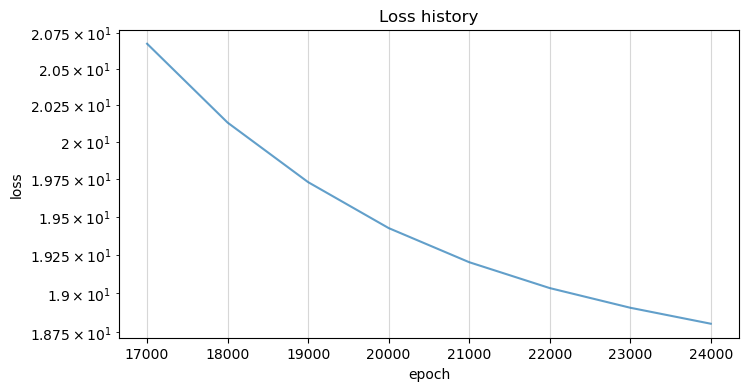

In [278]:
#with tf.device("/device:GPU:0"):
with tf.device("/device:CPU:0"):
    pinn.train(
        train_data=(
            t_d, c_d, u_0_d, u_d,
            t_0, c_0, u_0_0, u_0, 
            t_b, c_b, u_0_b, 
            t_r, c_r, u_0_r
        ),
        epochs=n_epch, 
        batch_size=n_btch, 
        convergence_tolerance=c_tol,
        #validation_data=(X_data_val_scaled, u_data_val_scaled), 
    )

plt.figure(figsize=(8, 4))
plt.plot(pinn.ep_log, pinn.loss_log, alpha=.7)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Loss history")
plt.grid(alpha=.5)
plt.show()


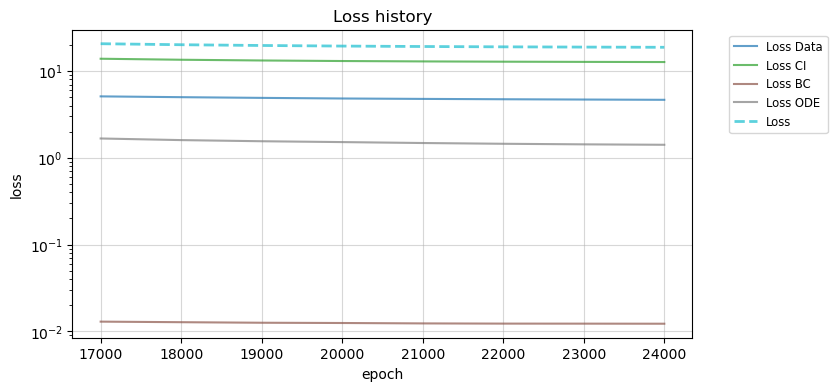

In [279]:
# plot each loss independently
plt.figure(figsize=(8, 4))
colors = plt.get_cmap('tab10', 5)
plt.plot(pinn.ep_log, pinn.loss_log_d, alpha=.7, color=colors(0), label="Loss Data" )
plt.plot(pinn.ep_log, pinn.loss_log_0, alpha=.7, color=colors(1), label="Loss CI" )
plt.plot(pinn.ep_log, pinn.loss_log_b, alpha=.7, color=colors(2), label="Loss BC")
plt.plot(pinn.ep_log, pinn.loss_log_r, alpha=.7, color=colors(3), label="Loss ODE")
plt.plot(pinn.ep_log, pinn.loss_log, '--', lw=2, alpha=.7, color=colors(4), label="Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Loss history")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(alpha=.5)
plt.show()

elapsed time for PINN inference (sec): 0.0033822059631347656


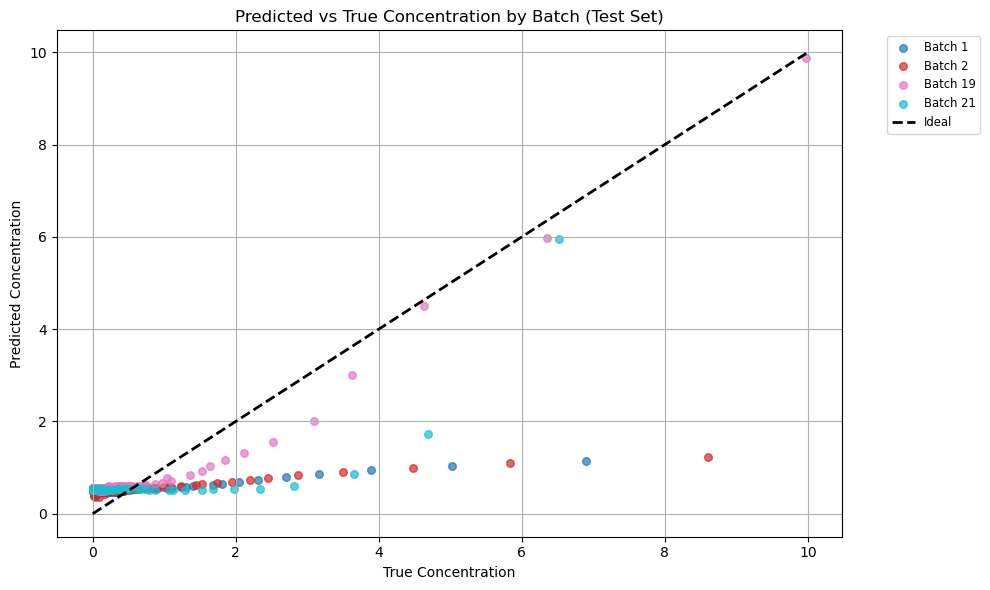

In [280]:
# PINN inference
t0 = time.time()
u_hat_scaled = pinn.infer(X_data_val_scaled[:, 0:1], X_data_val_scaled[:, 1:2], X_data_val_scaled[:, 2:3])
t1 = time.time()
elps = t1 - t0
print("elapsed time for PINN inference (sec):", elps)

# Unscale predictions using the inverse transform of scaler_u
u_hat = scaler_u.inverse_transform(u_hat_scaled.numpy().reshape(-1, 1)).flatten()
plt.figure(figsize=(10, 6))
unique_val_groups = np.unique(val_groups)
colors = plt.get_cmap('tab10', len(unique_val_groups))

for idx, group in enumerate(unique_val_groups):
    mask = (val_groups == group)
    plt.scatter(
        u_data_val[mask], 
        u_hat[mask], 
        color=colors(idx), 
        label=f'Batch {int(group)}', 
        s=30, 
        alpha=0.7
    )

plt.plot([u_data_val.min(), u_data_val.max()], [u_data_val.min(), u_data_val.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('True Concentration')
plt.ylabel('Predicted Concentration')
plt.title('Predicted vs True Concentration by Batch (Test Set)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


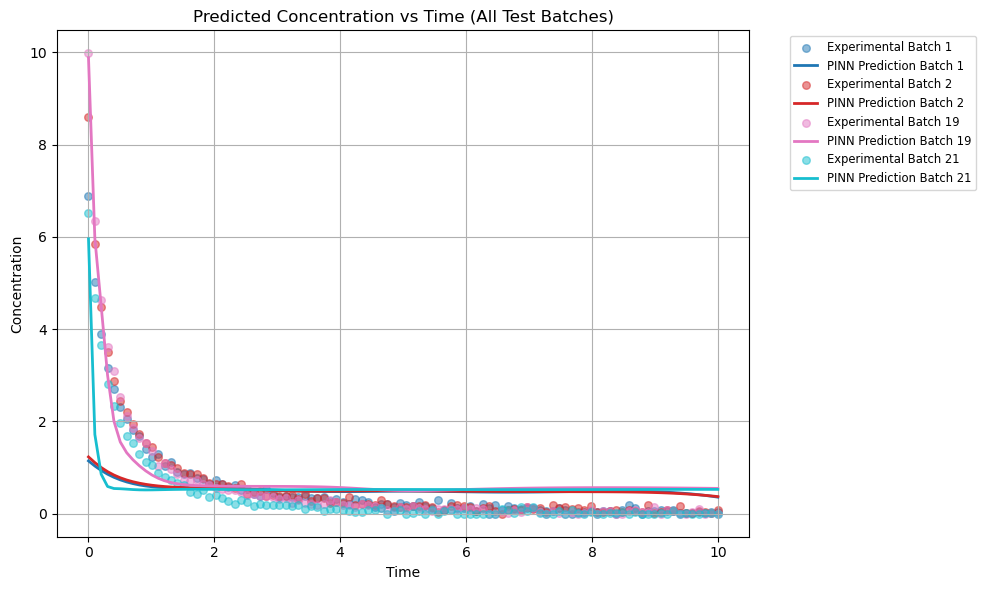

In [281]:
plt.figure(figsize=(10, 6))

unique_val_groups = np.unique(val_groups)
colors = plt.get_cmap('tab10', len(unique_val_groups))

for idx, group in enumerate(unique_val_groups):
    mask = val_groups == group
    t_batch = X_data_val[mask, 0]
    Ccat_batch = X_data_val[mask, 1]
    u_hat_batch = u_hat[mask]
    u_batch = u_data_val[mask]
    plt.scatter(t_batch, u_batch, label=f'Experimental Batch {int(group)}', color=colors(idx), s=30, alpha=0.5)
    plt.plot(t_batch, u_hat_batch, label=f'PINN Prediction Batch {int(group)}', color=colors(idx), linewidth=2)

plt.title('Predicted Concentration vs Time (All Test Batches)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


As one can see, PINNs are not trivial.

I would likely need to sweep through hyperparameters to obtain useful results. This will be for another time!

To be finished!

Sources of code for inspiration:

https://github.com/kochlisGit/Physics-Informed-Neural-Network-PINN-Tensorflow/blob/main/TF_PINN_Higher_Order_PDEs.ipynb

https://github.com/ShotaDeguchi/PINN_TF2/tree/main/04_diffusion

https://github.com/DENG-MIT/Stiff-PINN/tree/main/robertson_pinn